In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from sklearn import tree
from sklearn import preprocessing, model_selection
from sklearn import metrics
from scipy import stats
from scipy.stats import norm


from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


%matplotlib inline

# Automóveis


## Leitura da Base 

In [3]:
df_auto = pandas.read_csv('../Data/dataset_auto.csv',sep=';')
df_auto['model'] = df_auto['brand'].astype(str) + df_auto['model'].astype(str)

auto_target_col = 'price'

drop_cols = ['brand','tax']
df_auto.drop(drop_cols, axis=1, inplace=True)
print(df_auto.shape)
df_auto.head()

(15000, 8)


,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,audi A1,2020,20000,Manual,5000,Petrol,49.6,1.0
1,audi A5,2017,19995,Semi-Auto,54000,Diesel,67.3,2.0
2,audi A3,2017,11895,Manual,28334,Petrol,62.8,1.0
3,audi Q7,2018,56900,Semi-Auto,5330,Diesel,39.2,4.0
4,audi A4,2019,27160,Semi-Auto,17790,Diesel,47.9,2.0


# Transformação Variáveis Categóricas

In [4]:
categorical_cols = ['transmission', 'fuelType', 'model']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_auto[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_auto = pandas.concat([df_auto, ohe_df], axis=1).drop(cname, axis=1)
df_auto.head()

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,...,model_ford Ka+,model_ford Kuga,model_ford Mondeo,model_ford Mustang,model_ford Puma,model_ford S-MAX,model_ford Streetka,model_ford Tourneo Connect,model_ford Tourneo Custom,model_ford Transit Tourneo
0,2020,20000,5000,49.6,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,19995,54000,67.3,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,11895,28334,62.8,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,56900,5330,39.2,4.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,27160,17790,47.9,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Treinamento do Modelo 

In [5]:
tree.DecisionTreeRegressor?

Init signature:
tree.DecisionTreeRegressor(
    *,
    criterion='mse',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"mse", "friedman_mse", "mae", "poisson"}, default="mse"
    The function to measure the quality of a split. Supported criteria
    are "mse" for the mean squared error, which is equal to variance
    reduction as feature selection criterion and minimizes the L2 loss
    using the mean of each terminal node, "friedman_mse", which uses mean
    squared error with Friedman's improvement score for potential splits,
    "mae" for the mean absolute error, which minimizes the L1 loss using
    the median of each terminal node, and

In [6]:

Y = df_auto[auto_target_col]
X = df_auto.drop(auto_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[auto_target_col] = ytrain
df_test[auto_target_col] = ytest


model_auto = tree.DecisionTreeRegressor(criterion='mse', max_depth = 10)
model_auto.fit(xtrain, ytrain)      
df_train['prediction'] = model_auto.predict(xtrain)
df_test['prediction']  = model_auto.predict(xtest)

df_auto = pandas.concat((df_train, df_test), axis=0)

## Curva de Resíduos

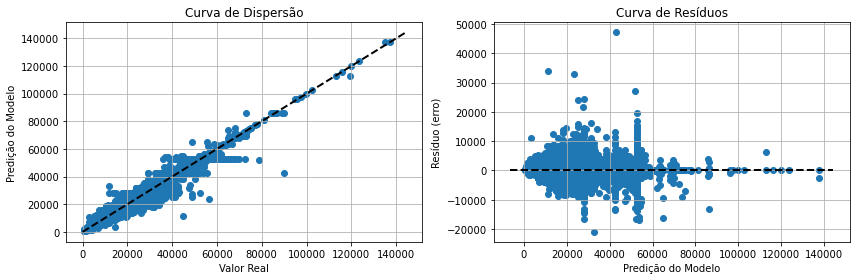

In [8]:
plt.figure(figsize=(12,4))

# Dispersion plot
plt.subplot(1,2,1)
plt.scatter(df_auto[auto_target_col], df_auto['prediction'])
plt.plot([0, plt.gca().axis()[3]],[0, plt.gca().axis()[3]],  '--k', lw=2)
plt.grid()
plt.ylabel('Predição do Modelo')
plt.xlabel('Valor Real')
plt.title(f'Curva de Dispersão')
plt.tight_layout()

plt.subplot(1,2,2)
error = df_auto[auto_target_col] - df_auto['prediction']
plt.scatter(df_auto['prediction'], error)
plt.plot([plt.gca().axis()[0], plt.gca().axis()[1]],[0, 0],  '--k', lw=2)
plt.grid()
plt.ylabel('Resíduo (erro)')
plt.xlabel('Predição do Modelo')
plt.title(f'Curva de Resíduos')
plt.tight_layout()

## Teste de Normalidade do Erro 

mu = 0.12 and sigma = 2655.56
Shapiro-Wilk p-value: 0.0


C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


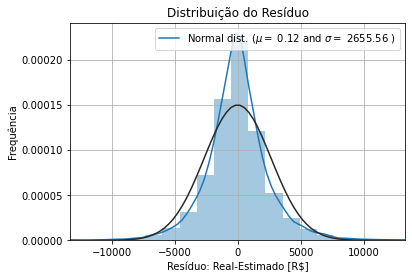

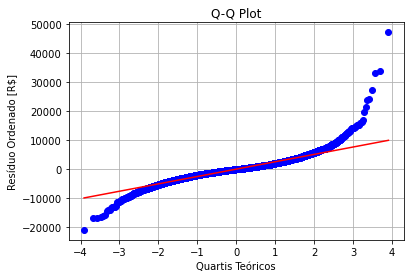

In [9]:

error = df_auto[auto_target_col] - df_auto['prediction']
(mu, sigma) = norm.fit(error.values.reshape((-1, 1)))
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
_, p_value = stats.shapiro(error)
print('Shapiro-Wilk p-value: ' + str(p_value))
# Get the fitted parameters used by the function
sns.distplot(error , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.xlabel('Resíduo: Real-Estimado [R$]')
plt.title(f'Distribuição do Resíduo')
plt.xlim((mu-5*sigma, mu+5*sigma))
plt.grid(True)
plt.show()
#Get also the QQ-plot
res = stats.probplot(error, plot=plt)
plt.xlabel('Quartis Teóricos')
plt.title(f'Q-Q Plot')
plt.ylabel('Resíduo Ordenado [R$]')
plt.grid(True)
plt.show()


## Métricas de Regressão

In [10]:
def print_regression_report(ytrue, ypred, dset):
    measurement_dict = {
        'mean_absolute_error': metrics.mean_absolute_error(ytrue, ypred),
        'mean_squared_error': metrics.mean_squared_error(ytrue, ypred),
        'root_mean_squared_error': np.sqrt(metrics.mean_squared_error(ytrue, ypred)),
        'median_absolute_error': metrics.median_absolute_error(ytrue, ypred),
        'r2': metrics.r2_score(ytrue, ypred),
        'mean_absolute_percentage_error': metrics.mean_absolute_percentage_error(ytrue, ypred),
    }
    df =  pandas.DataFrame.from_dict(measurement_dict, orient='index')
    df.columns=[dset]
    return df
   
print_regression_report(df_auto[auto_target_col], df_auto['prediction'], 'auto')

,auto
mean_absolute_error,1.801368e+03
mean_squared_error,7.051999e+06
root_mean_squared_error,2.655560e+03
median_absolute_error,1.251780e+03
r2,9.421085e-01
mean_absolute_percentage_error,1.044061e-01


#  Clima

## Leitura da Base 

In [11]:
df_weather = pandas.read_csv('../Data/dataset_clima.csv',sep=';')

drop_cols = ['Temperature (C)']
df_weather.drop(drop_cols, axis=1, inplace=True)

print(df_weather.shape)

weather_target_col = 'Apparent Temperature (C)'

df_weather.head()

(4019, 7)


,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,-4.050000,0.890000,17.114300,140.000000,9.982000,0.0,1016.660000
1,-0.174537,0.817083,21.229192,142.750000,11.348487,0.0,1011.985000
2,1.808796,0.847083,17.824713,164.583333,8.492079,0.0,1010.384167
3,0.445370,0.897083,7.726658,252.541667,9.223958,0.0,1021.170833
4,-0.663194,0.906667,12.152817,35.000000,8.352546,0.0,981.770833


## Treinamento do Modelo 

In [12]:

Y = df_weather[weather_target_col]
X = df_weather.drop(weather_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[weather_target_col] = ytrain
df_test[weather_target_col] = ytest


model_weather = tree.DecisionTreeRegressor(criterion='mse', max_depth = 10)
model_weather.fit(xtrain, ytrain)      
df_train['prediction'] = model_weather.predict(xtrain)
df_test['prediction']  = model_weather.predict(xtest)

df_weather = pandas.concat((df_train, df_test), axis=0)

## Curvas de Resíduo 

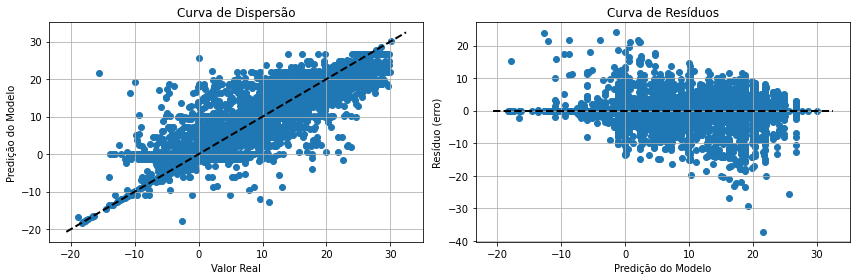

In [13]:
plt.figure(figsize=(12,4))

# Dispersion plot
plt.subplot(1,2,1)
plt.scatter(df_weather[weather_target_col], df_weather['prediction'])
plt.plot([plt.gca().axis()[2], plt.gca().axis()[3]],
         [plt.gca().axis()[2], plt.gca().axis()[3]],  '--k', lw=2)
plt.grid()
plt.ylabel('Predição do Modelo')
plt.xlabel('Valor Real')
plt.title(f'Curva de Dispersão')
plt.tight_layout()

plt.subplot(1,2,2)
error = df_weather[weather_target_col] - df_weather['prediction']
plt.scatter(df_weather['prediction'], error)
plt.plot([plt.gca().axis()[0], plt.gca().axis()[1]],[0, 0],  '--k', lw=2)
plt.grid()
plt.ylabel('Resíduo (erro)')
plt.xlabel('Predição do Modelo')
plt.title(f'Curva de Resíduos')
plt.tight_layout()

# Teste de Normalidade do Erro 

mu = -0.07 and sigma = 5.11
Shapiro-Wilk p-value: 2.5941211573419413e-33


C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


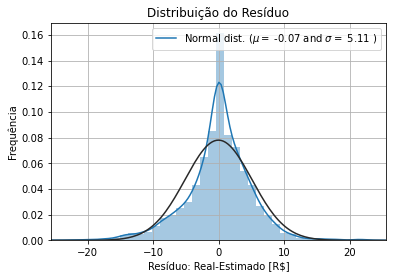

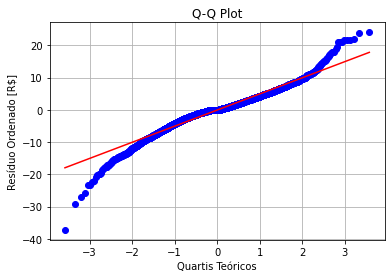

In [14]:
error = df_weather[weather_target_col] - df_weather['prediction']
(mu, sigma) = norm.fit(error.values.reshape((-1, 1)))
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
_, p_value = stats.shapiro(error)
print('Shapiro-Wilk p-value: ' + str(p_value))
# Get the fitted parameters used by the function
sns.distplot(error , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.xlabel('Resíduo: Real-Estimado [R$]')
plt.title(f'Distribuição do Resíduo')
plt.xlim((mu-5*sigma, mu+5*sigma))
plt.grid(True)
plt.show()
#Get also the QQ-plot
res = stats.probplot(error, plot=plt)
plt.xlabel('Quartis Teóricos')
plt.title(f'Q-Q Plot')
plt.ylabel('Resíduo Ordenado [R$]')
plt.grid(True)
plt.show()


## Métricas de Regressão 

In [15]:
print_regression_report(df_weather[weather_target_col], df_weather['prediction'], 'weather')

,weather
mean_absolute_error,3.567079
mean_squared_error,26.131955
root_mean_squared_error,5.111942
median_absolute_error,2.539931
r2,0.735431
mean_absolute_percentage_error,1.582650
